# **Advanced Deep Learning: CNN Image Classification Pipeline**

A production-level deep learning system with custom architecture, advanced regularization, callbacks, and comprehensive analysis.

In [1]:
# --- Import Libraries ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("Libraries loaded successfully!")

2026-01-30 17:25:40.968649: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-30 17:25:40.969192: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-30 17:25:41.074513: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2026-01-30 17:25:45.297204: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-30 17:25:45.312727: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow Version: 2.20.0
GPU Available: False
Libraries loaded successfully!


2026-01-30 17:25:46.363294: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
# --- Load Fashion-MNIST Dataset ---
print("=" * 60)
print("DATASET: FASHION-MNIST")
print("=" * 60)

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"\nTraining: {X_train_full.shape} | Test: {X_test.shape}")
print(f"Classes: {len(class_names)}")
print(f"Class Names: {class_names}")

DATASET: FASHION-MNIST



Training: (60000, 28, 28) | Test: (10000, 28, 28)
Classes: 10
Class Names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


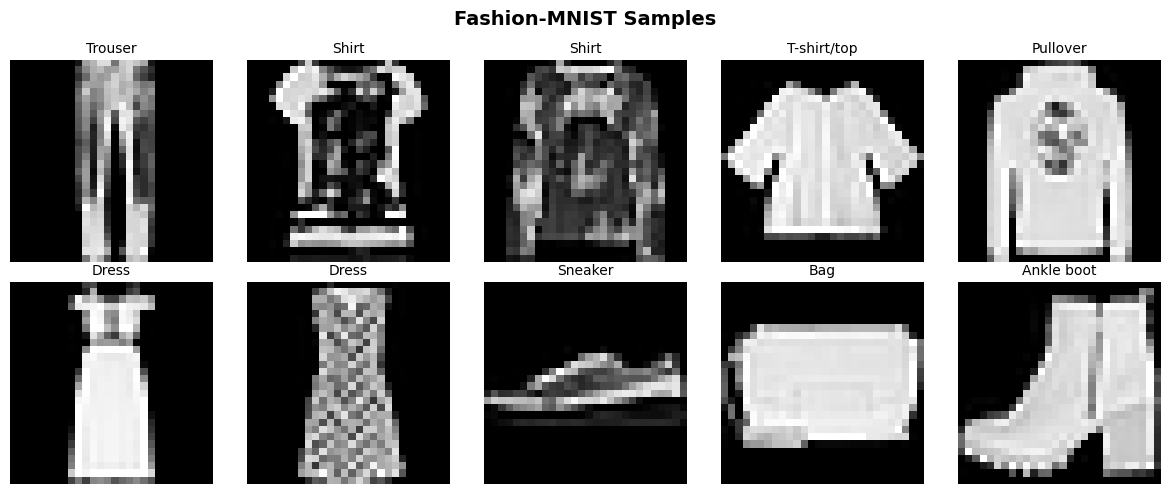

In [3]:
# --- Visualize Samples ---
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
np.random.seed(42)
for ax in axes.flat:
    idx = np.random.randint(0, len(X_train_full))
    ax.imshow(X_train_full[idx], cmap='gray')
    ax.set_title(class_names[y_train_full[idx]], fontsize=10)
    ax.axis('off')
plt.suptitle('Fashion-MNIST Samples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [4]:
# --- Data Preprocessing ---
print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train_full = X_train_full.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train, X_val = X_train_full[:15000], X_train_full[55000:]
y_train, y_val = y_train_full[:15000], y_train_full[55000:]

y_train_cat = to_categorical(y_train, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test, 10)

print(f"X_train: {X_train.shape} | X_val: {X_val.shape} | X_test: {X_test.shape}")

DATA PREPROCESSING


X_train: (15000, 28, 28, 1) | X_val: (5000, 28, 28, 1) | X_test: (10000, 28, 28, 1)


DATA AUGMENTATION
Augmentation: Rotation, Shift, Shear, Zoom, Flip


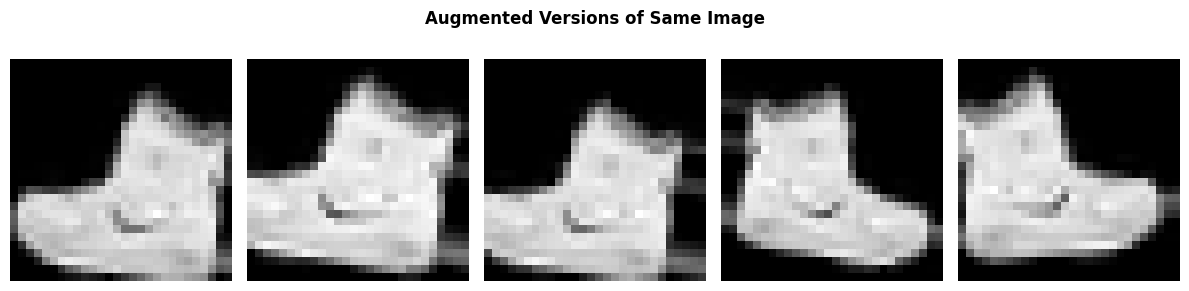

In [5]:
# --- Data Augmentation ---
print("=" * 60)
print("DATA AUGMENTATION")
print("=" * 60)

datagen = ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest'
)
datagen.fit(X_train)

print("Augmentation: Rotation, Shift, Shear, Zoom, Flip")

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
aug_iter = datagen.flow(X_train[0:1], batch_size=1)
for ax in axes:
    ax.imshow(next(aug_iter)[0].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle('Augmented Versions of Same Image', fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# --- Build CNN Model ---
print("=" * 60)
print("CNN ARCHITECTURE")
print("=" * 60)

model = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
], name='Advanced_CNN')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print(f"\nTotal Parameters: {model.count_params():,}")

CNN ARCHITECTURE


Model: "Advanced_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,746 (690.41 KB)

 Trainable params: 175,594 (685.91 KB)

 Non-trainable params: 1,152 (4.50 KB)


Total Parameters: 176,746


In [7]:
# --- Training Callbacks ---
print("=" * 60)
print("TRAINING CALLBACKS")
print("=" * 60)

callback_list = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
]
print("1. ReduceLROnPlateau: Reduces LR when validation loss plateaus")
print("2. EarlyStopping: Stops training if no improvement")

TRAINING CALLBACKS
1. ReduceLROnPlateau: Reduces LR when validation loss plateaus
2. EarlyStopping: Stops training if no improvement


In [8]:
# --- Train Model ---
print("=" * 60)
print("MODEL TRAINING")
print("=" * 60)

EPOCHS, BATCH_SIZE = 8, 128
print(f"Epochs: {EPOCHS} | Batch Size: {BATCH_SIZE}")
print(f"Training: {len(X_train)} | Validation: {len(X_val)}")
print("-" * 60)

history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    epochs=EPOCHS, validation_data=(X_val, y_val_cat),
    callbacks=callback_list, verbose=1
)
print("\nTRAINING COMPLETE")

MODEL TRAINING
Epochs: 8 | Batch Size: 128
Training: 15000 | Validation: 5000
------------------------------------------------------------


Epoch 1/8


  1/118 ━━━━━━━━━━━━━━━━━━━━ 14:14 7s/step - accuracy: 0.0703 - loss: 4.0396

  2/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.0957 - loss: 3.6893 

  3/118 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.1168 - loss: 3.4580

  4/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.1418 - loss: 3.2796

  6/118 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1773 - loss: 3.0596

  7/118 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1920 - loss: 2.9721

  8/118 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.2050 - loss: 2.8975

  9/118 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.2161 - loss: 2.8345

 10/118 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.2266 - loss: 2.7785

 11/118 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.2363 - loss: 2.7266

 13/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2532 - loss: 2.6375

 14/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2613 - loss: 2.5972

 16/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2761 - loss: 2.5241

 18/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2894 - loss: 2.4599

 19/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2954 - loss: 2.4307

 20/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3014 - loss: 2.4021

 21/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3072 - loss: 2.3746

 22/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3128 - loss: 2.3489

 23/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3181 - loss: 2.3247

 24/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3231 - loss: 2.3015

 26/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3327 - loss: 2.2584

 27/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3372 - loss: 2.2383

 28/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3416 - loss: 2.2192

 30/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3497 - loss: 2.1838

 32/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.3573 - loss: 2.1511

 34/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.3644 - loss: 2.1204

 36/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.3712 - loss: 2.0919

 37/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.3743 - loss: 2.0787

 38/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.3775 - loss: 2.0657

 40/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3835 - loss: 2.0407

 41/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3864 - loss: 2.0287

 43/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3920 - loss: 2.0056

 44/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3946 - loss: 1.9947

 46/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3998 - loss: 1.9734

 47/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4023 - loss: 1.9632

 48/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4048 - loss: 1.9532

 49/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4071 - loss: 1.9435

 51/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4117 - loss: 1.9250

 52/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4140 - loss: 1.9160

 53/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4162 - loss: 1.9072

 54/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4183 - loss: 1.8986

 55/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4204 - loss: 1.8903

 56/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4225 - loss: 1.8820

 57/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4245 - loss: 1.8740

 58/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4265 - loss: 1.8662

 59/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4285 - loss: 1.8585

 61/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4323 - loss: 1.8435

 62/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4341 - loss: 1.8363

 64/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4377 - loss: 1.8222

 66/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4413 - loss: 1.8085

 67/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4430 - loss: 1.8019

 68/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4447 - loss: 1.7953

 69/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4464 - loss: 1.7889

 70/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4480 - loss: 1.7826

 72/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4512 - loss: 1.7704

 73/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4527 - loss: 1.7644

 74/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4542 - loss: 1.7586

 75/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4557 - loss: 1.7529

 76/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4572 - loss: 1.7473

 77/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4586 - loss: 1.7417

 78/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4601 - loss: 1.7363

 79/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4615 - loss: 1.7309

 80/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4629 - loss: 1.7256

 81/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4642 - loss: 1.7204

 82/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4656 - loss: 1.7152

 83/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4670 - loss: 1.7100

 84/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4683 - loss: 1.7050

 85/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4696 - loss: 1.7000

 86/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4709 - loss: 1.6951

 87/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4721 - loss: 1.6902

 89/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4746 - loss: 1.6806

 90/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4759 - loss: 1.6760

 92/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4783 - loss: 1.6668

 93/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4795 - loss: 1.6623

 95/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4818 - loss: 1.6535

 96/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4829 - loss: 1.6491

 98/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4852 - loss: 1.6407

 99/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4863 - loss: 1.6366

100/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4873 - loss: 1.6325

101/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4884 - loss: 1.6285

102/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4895 - loss: 1.6246

103/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4905 - loss: 1.6207

104/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4916 - loss: 1.6168

105/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4926 - loss: 1.6129

106/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4937 - loss: 1.6091

107/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4947 - loss: 1.6054

108/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4957 - loss: 1.6016

109/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4967 - loss: 1.5980

111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4986 - loss: 1.5907

112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4996 - loss: 1.5872

114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5015 - loss: 1.5801

116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5033 - loss: 1.5732

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5051 - loss: 1.5665

118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.6102 - loss: 1.1758 - val_accuracy: 0.1234 - val_loss: 2.5292 - learning_rate: 0.0010


Epoch 2/8


  1/118 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.6328 - loss: 0.8891

  3/118 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6505 - loss: 0.9070  

  4/118 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6576 - loss: 0.8954

  5/118 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6656 - loss: 0.8741

  7/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.6785 - loss: 0.8482

  9/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6853 - loss: 0.8382

 10/118 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6879 - loss: 0.8347

 11/118 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6896 - loss: 0.8335

 12/118 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6912 - loss: 0.8314

 14/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6947 - loss: 0.8261

 16/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6969 - loss: 0.8247

 17/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6975 - loss: 0.8245

 19/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6977 - loss: 0.8253

 20/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6977 - loss: 0.8255

 22/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6973 - loss: 0.8267

 24/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6969 - loss: 0.8277

 25/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6968 - loss: 0.8279

 27/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6971 - loss: 0.8271

 28/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6974 - loss: 0.8266

 29/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6975 - loss: 0.8264

 30/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6976 - loss: 0.8262

 31/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6978 - loss: 0.8259

 32/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6980 - loss: 0.8258

 33/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6981 - loss: 0.8256

 34/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6983 - loss: 0.8255

 35/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6984 - loss: 0.8254

 36/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.6986 - loss: 0.8253

 38/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6988 - loss: 0.8252

 39/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6989 - loss: 0.8252

 41/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6990 - loss: 0.8252

 42/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6991 - loss: 0.8252

 43/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6992 - loss: 0.8252

 45/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6993 - loss: 0.8250

 47/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6996 - loss: 0.8248

 49/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6998 - loss: 0.8244

 51/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7001 - loss: 0.8242

 52/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7002 - loss: 0.8240

 54/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7005 - loss: 0.8237

 56/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7008 - loss: 0.8232

 57/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7009 - loss: 0.8230

 58/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7011 - loss: 0.8228

 60/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7014 - loss: 0.8223

 61/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7015 - loss: 0.8220

 62/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7017 - loss: 0.8217

 63/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7019 - loss: 0.8213

 64/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7021 - loss: 0.8209

 65/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7022 - loss: 0.8206

 66/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7024 - loss: 0.8202

 67/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7026 - loss: 0.8199

 68/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7028 - loss: 0.8195

 69/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7030 - loss: 0.8191

 70/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7032 - loss: 0.8186

 72/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7035 - loss: 0.8177

 73/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7037 - loss: 0.8173

 74/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7039 - loss: 0.8168

 75/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7041 - loss: 0.8163

 76/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7043 - loss: 0.8159

 77/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7045 - loss: 0.8154

 78/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7047 - loss: 0.8150

 80/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7051 - loss: 0.8141

 81/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7052 - loss: 0.8136

 82/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7054 - loss: 0.8132

 83/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7056 - loss: 0.8127

 84/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7058 - loss: 0.8123

 86/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7061 - loss: 0.8114

 88/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7065 - loss: 0.8105

 90/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7068 - loss: 0.8097

 92/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7072 - loss: 0.8088

 93/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7073 - loss: 0.8084

 94/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7075 - loss: 0.8080

 95/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7077 - loss: 0.8076

 96/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7078 - loss: 0.8071

 98/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7081 - loss: 0.8063

 99/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7083 - loss: 0.8059

101/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7086 - loss: 0.8051

103/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7089 - loss: 0.8043

104/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7091 - loss: 0.8039

105/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7092 - loss: 0.8035

107/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7095 - loss: 0.8028

108/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7097 - loss: 0.8024

110/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7099 - loss: 0.8017

111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7101 - loss: 0.8013

112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7102 - loss: 0.8010

113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7104 - loss: 0.8006

114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7105 - loss: 0.8003

115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7107 - loss: 0.7999

116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7108 - loss: 0.7995

117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7109 - loss: 0.7992

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7111 - loss: 0.7988

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.7274 - loss: 0.7560 - val_accuracy: 0.0980 - val_loss: 3.1007 - learning_rate: 0.0010


Epoch 3/8


  1/118 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.7266 - loss: 0.7322

  2/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7324 - loss: 0.7061  

  4/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7381 - loss: 0.6816

  6/118 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7439 - loss: 0.6720

  8/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7433 - loss: 0.6774

  9/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7425 - loss: 0.6814

 10/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7419 - loss: 0.6855

 12/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7412 - loss: 0.6895

 13/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7411 - loss: 0.6904

 15/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7409 - loss: 0.6913

 16/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7411 - loss: 0.6915

 17/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7414 - loss: 0.6911

 19/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7420 - loss: 0.6899

 21/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7426 - loss: 0.6885

 23/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7432 - loss: 0.6869

 24/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7436 - loss: 0.6862

 26/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7443 - loss: 0.6853

 28/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7450 - loss: 0.6845

 29/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7453 - loss: 0.6843

 31/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7457 - loss: 0.6838

 33/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7463 - loss: 0.6831

 34/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7466 - loss: 0.6827

 36/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7472 - loss: 0.6816

 38/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7478 - loss: 0.6805

 40/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7483 - loss: 0.6797

 42/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7487 - loss: 0.6790

 44/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7491 - loss: 0.6785

 46/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7495 - loss: 0.6780

 47/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7496 - loss: 0.6777

 49/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7500 - loss: 0.6772

 51/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7503 - loss: 0.6766

 53/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7506 - loss: 0.6760

 54/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7508 - loss: 0.6757

 55/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7510 - loss: 0.6754

 57/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7513 - loss: 0.6746

 59/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7516 - loss: 0.6739

 60/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7518 - loss: 0.6735

 62/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7521 - loss: 0.6727

 63/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7523 - loss: 0.6724

 64/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7524 - loss: 0.6720

 66/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7527 - loss: 0.6713

 68/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7530 - loss: 0.6705

 70/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7533 - loss: 0.6698

 71/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7534 - loss: 0.6695

 73/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7537 - loss: 0.6688

 75/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7540 - loss: 0.6681

 76/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7541 - loss: 0.6678

 78/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7544 - loss: 0.6671

 80/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7546 - loss: 0.6665

 81/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7548 - loss: 0.6661

 82/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7549 - loss: 0.6658

 83/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7550 - loss: 0.6655

 85/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7553 - loss: 0.6649

 87/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7555 - loss: 0.6643

 89/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7557 - loss: 0.6637

 91/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7559 - loss: 0.6632

 93/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7562 - loss: 0.6626

 94/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7563 - loss: 0.6624

 95/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7564 - loss: 0.6621

 97/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7566 - loss: 0.6616

 98/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7567 - loss: 0.6613

 99/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7568 - loss: 0.6611

100/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7569 - loss: 0.6608

102/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7571 - loss: 0.6604

104/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7573 - loss: 0.6600

106/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7574 - loss: 0.6597

108/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7576 - loss: 0.6593

109/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7577 - loss: 0.6591

111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7578 - loss: 0.6587

113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7580 - loss: 0.6583

115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7581 - loss: 0.6579

117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7583 - loss: 0.6576


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.7668 - loss: 0.6360 - val_accuracy: 0.1980 - val_loss: 3.1694 - learning_rate: 0.0010


Epoch 4/8


  1/118 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.8047 - loss: 0.5272

  2/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8125 - loss: 0.5031  

  3/118 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8134 - loss: 0.5004

  4/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8107 - loss: 0.5121

  5/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8054 - loss: 0.5254

  7/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7991 - loss: 0.5434

  8/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7976 - loss: 0.5465

  9/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7970 - loss: 0.5479

 10/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7967 - loss: 0.5488

 11/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7962 - loss: 0.5499

 12/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7954 - loss: 0.5511

 13/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7945 - loss: 0.5527

 14/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7938 - loss: 0.5545

 15/118 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7932 - loss: 0.5562

 16/118 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7926 - loss: 0.5578

 18/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7914 - loss: 0.5611

 19/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7908 - loss: 0.5626

 20/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7902 - loss: 0.5640

 21/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7898 - loss: 0.5649

 23/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7891 - loss: 0.5661

 24/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7890 - loss: 0.5665

 26/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7887 - loss: 0.5670

 27/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7886 - loss: 0.5671

 28/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7886 - loss: 0.5671

 29/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7886 - loss: 0.5672

 30/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7886 - loss: 0.5672

 31/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7886 - loss: 0.5670

 32/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7887 - loss: 0.5668

 33/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7888 - loss: 0.5666

 34/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7889 - loss: 0.5663

 35/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7889 - loss: 0.5661

 36/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7890 - loss: 0.5658

 37/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7891 - loss: 0.5655

 38/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7893 - loss: 0.5652

 39/118 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7894 - loss: 0.5650

 41/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7896 - loss: 0.5648

 42/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7897 - loss: 0.5648

 43/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7898 - loss: 0.5648

 45/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7900 - loss: 0.5646

 46/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7901 - loss: 0.5646

 47/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7902 - loss: 0.5645

 49/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7905 - loss: 0.5642

 50/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7907 - loss: 0.5640

 52/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7910 - loss: 0.5635

 54/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7912 - loss: 0.5634

 55/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7913 - loss: 0.5633

 57/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7915 - loss: 0.5633

 58/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7916 - loss: 0.5633

 59/118 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7917 - loss: 0.5632

 60/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7918 - loss: 0.5632

 61/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7919 - loss: 0.5632

 62/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7920 - loss: 0.5631

 64/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7922 - loss: 0.5629

 66/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7924 - loss: 0.5627

 67/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7925 - loss: 0.5626

 68/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7926 - loss: 0.5625

 69/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7927 - loss: 0.5624

 70/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7927 - loss: 0.5623

 72/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7929 - loss: 0.5620

 73/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7930 - loss: 0.5619

 75/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7931 - loss: 0.5617

 76/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7932 - loss: 0.5616

 77/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7933 - loss: 0.5615

 78/118 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7933 - loss: 0.5614

 80/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7934 - loss: 0.5613

 81/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7935 - loss: 0.5612

 82/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7935 - loss: 0.5612

 83/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7936 - loss: 0.5611

 84/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7936 - loss: 0.5610

 85/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7937 - loss: 0.5610

 86/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7937 - loss: 0.5609

 88/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7939 - loss: 0.5607

 89/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7939 - loss: 0.5606

 90/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7940 - loss: 0.5605

 91/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7941 - loss: 0.5604

 93/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7942 - loss: 0.5602

 95/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7943 - loss: 0.5600

 96/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7944 - loss: 0.5599

 97/118 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7945 - loss: 0.5599

 99/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7946 - loss: 0.5597

101/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7947 - loss: 0.5596

103/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7948 - loss: 0.5594

104/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7948 - loss: 0.5593

106/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7949 - loss: 0.5592

108/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7950 - loss: 0.5590

110/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7951 - loss: 0.5589

112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7952 - loss: 0.5587

113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7952 - loss: 0.5586

114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7953 - loss: 0.5585

115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7953 - loss: 0.5585

116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7954 - loss: 0.5584

117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7954 - loss: 0.5583

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7954 - loss: 0.5582

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.7993 - loss: 0.5492 - val_accuracy: 0.6366 - val_loss: 0.9381 - learning_rate: 5.0000e-04


Epoch 5/8


  1/118 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.8047 - loss: 0.5620

  3/118 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8099 - loss: 0.5209  

  5/118 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8089 - loss: 0.5081

  7/118 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8114 - loss: 0.5001

  9/118 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8126 - loss: 0.4965

 11/118 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8116 - loss: 0.4975

 13/118 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8111 - loss: 0.4983

 15/118 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8111 - loss: 0.4979

 17/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8114 - loss: 0.4976

 18/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8116 - loss: 0.4977

 19/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8116 - loss: 0.4979

 20/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8114 - loss: 0.4984

 22/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8110 - loss: 0.4993

 24/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8104 - loss: 0.5008

 26/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8099 - loss: 0.5023

 28/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8094 - loss: 0.5036

 30/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8089 - loss: 0.5050

 31/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8086 - loss: 0.5058

 32/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8084 - loss: 0.5062

 33/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8083 - loss: 0.5067

 35/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8079 - loss: 0.5076

 37/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8076 - loss: 0.5084

 39/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8073 - loss: 0.5092

 41/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8071 - loss: 0.5097

 42/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8069 - loss: 0.5101

 43/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8068 - loss: 0.5105

 44/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8067 - loss: 0.5109

 45/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8065 - loss: 0.5113

 46/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8064 - loss: 0.5116

 47/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8063 - loss: 0.5119

 48/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8062 - loss: 0.5122

 50/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8060 - loss: 0.5129

 51/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8059 - loss: 0.5132

 53/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8056 - loss: 0.5139

 54/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8055 - loss: 0.5142

 55/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8054 - loss: 0.5145

 56/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8053 - loss: 0.5149

 57/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8052 - loss: 0.5152

 58/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8051 - loss: 0.5155

 59/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8050 - loss: 0.5158

 61/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8048 - loss: 0.5165

 63/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8046 - loss: 0.5171

 64/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8046 - loss: 0.5173

 66/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8044 - loss: 0.5179

 68/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8044 - loss: 0.5183

 70/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8043 - loss: 0.5187

 72/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8043 - loss: 0.5191

 74/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8043 - loss: 0.5194

 76/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8043 - loss: 0.5198

 77/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8043 - loss: 0.5199

 79/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8043 - loss: 0.5202

 81/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8042 - loss: 0.5204

 83/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8042 - loss: 0.5206

 84/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8042 - loss: 0.5207

 85/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8042 - loss: 0.5208

 87/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8042 - loss: 0.5209

 88/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8042 - loss: 0.5210

 89/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8042 - loss: 0.5210

 90/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8042 - loss: 0.5211

 91/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8042 - loss: 0.5211

 92/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8042 - loss: 0.5211

 93/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8042 - loss: 0.5212

 95/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8043 - loss: 0.5212

 97/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8043 - loss: 0.5211

 99/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8044 - loss: 0.5210

101/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8044 - loss: 0.5210

102/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8045 - loss: 0.5210

103/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8045 - loss: 0.5210

104/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8045 - loss: 0.5209

105/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8045 - loss: 0.5209

106/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8046 - loss: 0.5209

107/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8046 - loss: 0.5208

108/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8046 - loss: 0.5208

109/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8046 - loss: 0.5208

110/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8047 - loss: 0.5208

111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8047 - loss: 0.5208

112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8047 - loss: 0.5208

113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8048 - loss: 0.5208

114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8048 - loss: 0.5208

116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8048 - loss: 0.5208

117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8048 - loss: 0.5208

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8049 - loss: 0.5208

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8074 - loss: 0.5225 - val_accuracy: 0.8098 - val_loss: 0.5187 - learning_rate: 5.0000e-04


Epoch 6/8


  1/118 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.8125 - loss: 0.5562

  2/118 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8066 - loss: 0.5524  

  3/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8034 - loss: 0.5592

  4/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8013 - loss: 0.5676

  6/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7974 - loss: 0.5749

  8/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7970 - loss: 0.5711

 10/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7977 - loss: 0.5653

 12/118 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7981 - loss: 0.5612

 14/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7990 - loss: 0.5575

 15/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7992 - loss: 0.5561

 17/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7996 - loss: 0.5529

 19/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8003 - loss: 0.5495

 21/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8008 - loss: 0.5469

 23/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8015 - loss: 0.5443

 24/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8019 - loss: 0.5428

 26/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8027 - loss: 0.5401

 28/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8035 - loss: 0.5377

 30/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8040 - loss: 0.5361

 32/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8046 - loss: 0.5345

 34/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8051 - loss: 0.5329

 36/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8056 - loss: 0.5313

 38/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8061 - loss: 0.5297

 40/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8066 - loss: 0.5282

 42/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8071 - loss: 0.5267

 44/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8076 - loss: 0.5251

 45/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8078 - loss: 0.5244

 47/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8083 - loss: 0.5231

 48/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8085 - loss: 0.5224

 50/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8088 - loss: 0.5212

 52/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8092 - loss: 0.5200

 54/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8094 - loss: 0.5191

 56/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8097 - loss: 0.5182

 57/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8099 - loss: 0.5177

 59/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8102 - loss: 0.5169

 60/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8103 - loss: 0.5165

 61/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8104 - loss: 0.5161

 62/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8105 - loss: 0.5157

 64/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8107 - loss: 0.5151

 65/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8108 - loss: 0.5148

 67/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8110 - loss: 0.5141

 69/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8112 - loss: 0.5136

 71/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8114 - loss: 0.5131

 73/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8115 - loss: 0.5127

 75/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8116 - loss: 0.5123

 77/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8117 - loss: 0.5119

 79/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8118 - loss: 0.5117

 80/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8119 - loss: 0.5116

 82/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8119 - loss: 0.5114

 84/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8119 - loss: 0.5112

 86/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8120 - loss: 0.5111

 88/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8120 - loss: 0.5109

 89/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8120 - loss: 0.5108

 90/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8121 - loss: 0.5107

 92/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8121 - loss: 0.5106

 93/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8121 - loss: 0.5105

 95/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8122 - loss: 0.5104

 97/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8122 - loss: 0.5104

 98/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8122 - loss: 0.5103

100/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8122 - loss: 0.5102

101/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8122 - loss: 0.5102

102/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8122 - loss: 0.5102

103/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8123 - loss: 0.5101

104/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8123 - loss: 0.5101

106/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8123 - loss: 0.5100

108/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8123 - loss: 0.5099

109/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8123 - loss: 0.5098

111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8123 - loss: 0.5098

113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8123 - loss: 0.5097

115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8123 - loss: 0.5097

116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8123 - loss: 0.5097

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8124 - loss: 0.5096

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8127 - loss: 0.5070 - val_accuracy: 0.8148 - val_loss: 0.4918 - learning_rate: 5.0000e-04


Epoch 7/8


  1/118 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.8125 - loss: 0.5292

  2/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8066 - loss: 0.5461  

  3/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8069 - loss: 0.5390

  4/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8083 - loss: 0.5333

  5/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8069 - loss: 0.5374

  6/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8066 - loss: 0.5385

  7/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8060 - loss: 0.5404

  8/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8058 - loss: 0.5397

 10/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8052 - loss: 0.5390

 12/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8055 - loss: 0.5395

 13/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8061 - loss: 0.5383

 15/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8073 - loss: 0.5358

 17/118 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8083 - loss: 0.5321

 18/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8086 - loss: 0.5309

 19/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8090 - loss: 0.5296

 21/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8100 - loss: 0.5273

 23/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8107 - loss: 0.5254

 25/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8112 - loss: 0.5238

 26/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8114 - loss: 0.5230

 28/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8119 - loss: 0.5212

 30/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8123 - loss: 0.5197

 32/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8129 - loss: 0.5183

 33/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8131 - loss: 0.5176

 34/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8134 - loss: 0.5169

 35/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8136 - loss: 0.5163

 36/118 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8138 - loss: 0.5157

 38/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8142 - loss: 0.5144

 40/118 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8146 - loss: 0.5133

 42/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8150 - loss: 0.5122

 44/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8154 - loss: 0.5112

 46/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8156 - loss: 0.5102

 48/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8160 - loss: 0.5092

 50/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8163 - loss: 0.5082

 51/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8165 - loss: 0.5077

 53/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8168 - loss: 0.5067

 54/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8170 - loss: 0.5063

 56/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8172 - loss: 0.5055

 57/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8174 - loss: 0.5051

 58/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8175 - loss: 0.5046

 60/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8178 - loss: 0.5037

 62/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8182 - loss: 0.5028

 64/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8184 - loss: 0.5020

 66/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8187 - loss: 0.5012

 67/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8188 - loss: 0.5009

 68/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8189 - loss: 0.5006

 69/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8190 - loss: 0.5003

 70/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8191 - loss: 0.5000

 71/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8192 - loss: 0.4997

 72/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8193 - loss: 0.4994

 74/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8195 - loss: 0.4989

 76/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8197 - loss: 0.4984

 77/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8197 - loss: 0.4981

 78/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8198 - loss: 0.4978

 79/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8199 - loss: 0.4976

 80/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8200 - loss: 0.4973

 82/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8202 - loss: 0.4967

 83/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8203 - loss: 0.4965

 85/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8204 - loss: 0.4960

 87/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8205 - loss: 0.4956

 89/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8207 - loss: 0.4951

 90/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8208 - loss: 0.4949

 92/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8209 - loss: 0.4944

 93/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8210 - loss: 0.4942

 95/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8212 - loss: 0.4937

 97/118 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8213 - loss: 0.4933

 99/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8214 - loss: 0.4930

101/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8215 - loss: 0.4926

102/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8216 - loss: 0.4924

103/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8216 - loss: 0.4923

104/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8217 - loss: 0.4921

105/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8217 - loss: 0.4919

107/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8218 - loss: 0.4916

108/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8219 - loss: 0.4914

110/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8220 - loss: 0.4911

112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8220 - loss: 0.4908

113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8221 - loss: 0.4907

115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8221 - loss: 0.4904

116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8222 - loss: 0.4903

117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8222 - loss: 0.4901

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8222 - loss: 0.4900

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8260 - loss: 0.4738 - val_accuracy: 0.8598 - val_loss: 0.3878 - learning_rate: 5.0000e-04


Epoch 8/8


  1/118 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.8750 - loss: 0.3293

  2/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8574 - loss: 0.3818  

  3/118 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8485 - loss: 0.4106

  5/118 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8395 - loss: 0.4325

  6/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8366 - loss: 0.4381

  8/118 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8349 - loss: 0.4437

  9/118 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8354 - loss: 0.4428

 10/118 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8359 - loss: 0.4411

 11/118 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8358 - loss: 0.4419

 13/118 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8353 - loss: 0.4440

 14/118 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8350 - loss: 0.4456

 15/118 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8345 - loss: 0.4476

 17/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8336 - loss: 0.4519

 18/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8331 - loss: 0.4540

 20/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8323 - loss: 0.4571

 21/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8321 - loss: 0.4584

 22/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8318 - loss: 0.4595

 24/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8314 - loss: 0.4612

 25/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8312 - loss: 0.4620

 26/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8310 - loss: 0.4625

 27/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8309 - loss: 0.4629

 29/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8306 - loss: 0.4638

 31/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8303 - loss: 0.4645

 32/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8302 - loss: 0.4649

 33/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8301 - loss: 0.4652

 34/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8300 - loss: 0.4655

 35/118 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8299 - loss: 0.4659

 37/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8296 - loss: 0.4665

 39/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8295 - loss: 0.4669

 41/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8294 - loss: 0.4671

 43/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8294 - loss: 0.4672

 44/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8294 - loss: 0.4673

 45/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8294 - loss: 0.4673

 46/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8295 - loss: 0.4673

 48/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8295 - loss: 0.4673

 49/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8295 - loss: 0.4673

 50/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8296 - loss: 0.4672

 52/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8296 - loss: 0.4671

 53/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8296 - loss: 0.4671

 54/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8296 - loss: 0.4671

 55/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8297 - loss: 0.4670

 57/118 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8297 - loss: 0.4670

 59/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8297 - loss: 0.4669

 60/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8298 - loss: 0.4669

 62/118 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8298 - loss: 0.4669

 63/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8298 - loss: 0.4669

 64/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8298 - loss: 0.4669

 66/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8299 - loss: 0.4669

 67/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8299 - loss: 0.4669

 69/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8299 - loss: 0.4669

 70/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8299 - loss: 0.4668

 71/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8300 - loss: 0.4668

 72/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8300 - loss: 0.4667

 73/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8300 - loss: 0.4667

 74/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8301 - loss: 0.4666

 75/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8301 - loss: 0.4666

 76/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8301 - loss: 0.4666

 77/118 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8302 - loss: 0.4665

 79/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8302 - loss: 0.4664

 80/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8302 - loss: 0.4664

 81/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8302 - loss: 0.4663

 82/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8302 - loss: 0.4663

 83/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8302 - loss: 0.4663

 84/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8302 - loss: 0.4662

 85/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8302 - loss: 0.4662

 87/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8302 - loss: 0.4661

 88/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8302 - loss: 0.4660

 89/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8302 - loss: 0.4659

 91/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8303 - loss: 0.4658

 93/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8303 - loss: 0.4657

 94/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8303 - loss: 0.4656

 95/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8303 - loss: 0.4656

 96/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8304 - loss: 0.4655

 97/118 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8304 - loss: 0.4655

 98/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8304 - loss: 0.4654

 99/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8304 - loss: 0.4654

100/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8305 - loss: 0.4653

101/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8305 - loss: 0.4652

102/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8305 - loss: 0.4652

103/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8305 - loss: 0.4651

104/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8306 - loss: 0.4651

105/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8306 - loss: 0.4650

106/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8306 - loss: 0.4649

108/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8306 - loss: 0.4648

109/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8306 - loss: 0.4647

110/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8307 - loss: 0.4647

111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8307 - loss: 0.4646

112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8307 - loss: 0.4645

113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8307 - loss: 0.4645

114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8307 - loss: 0.4644

115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8308 - loss: 0.4643

116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8308 - loss: 0.4642

117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8308 - loss: 0.4641

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8308 - loss: 0.4641

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8335 - loss: 0.4549 - val_accuracy: 0.8104 - val_loss: 0.5401 - learning_rate: 5.0000e-04


Restoring model weights from the end of the best epoch: 7.



TRAINING COMPLETE


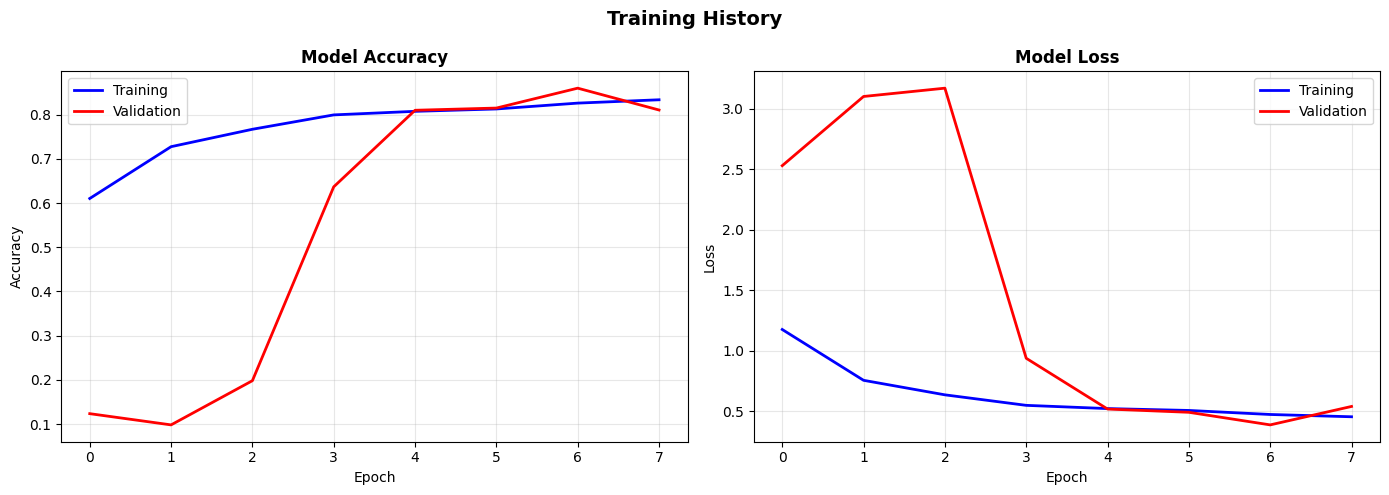

Best Validation Accuracy: 0.8598


In [9]:
# --- Training History ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], 'b-', label='Training', linewidth=2)
axes[0].plot(history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Accuracy')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], 'b-', label='Training', linewidth=2)
axes[1].plot(history.history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

In [10]:
# --- Test Evaluation ---
print("=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)

test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
max_probs = np.max(y_pred_prob, axis=1)

print(f"\nPrediction Confidence: Mean={max_probs.mean():.4f}, Min={max_probs.min():.4f}, Max={max_probs.max():.4f}")

TEST SET EVALUATION



Test Accuracy: 0.8570 (85.70%)
Test Loss: 0.4060



Prediction Confidence: Mean=0.8672, Min=0.2174, Max=1.0000


In [11]:
# --- Classification Report ---
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

 T-shirt/top     0.8276    0.8110    0.8192      1000
     Trouser     0.9559    0.9750    0.9653      1000
    Pullover     0.8839    0.7460    0.8091      1000
       Dress     0.8342    0.8500    0.8420      1000
        Coat     0.7699    0.7360    0.7526      1000
      Sandal     0.9504    0.9580    0.9542      1000
       Shirt     0.5693    0.6610    0.6118      1000
     Sneaker     0.8919    0.9570    0.9233      1000
         Bag     0.9547    0.9700    0.9623      1000
  Ankle boot     0.9816    0.9060    0.9423      1000

    accuracy                         0.8570     10000
   macro avg     0.8619    0.8570    0.8582     10000
weighted avg     0.8619    0.8570    0.8582     10000



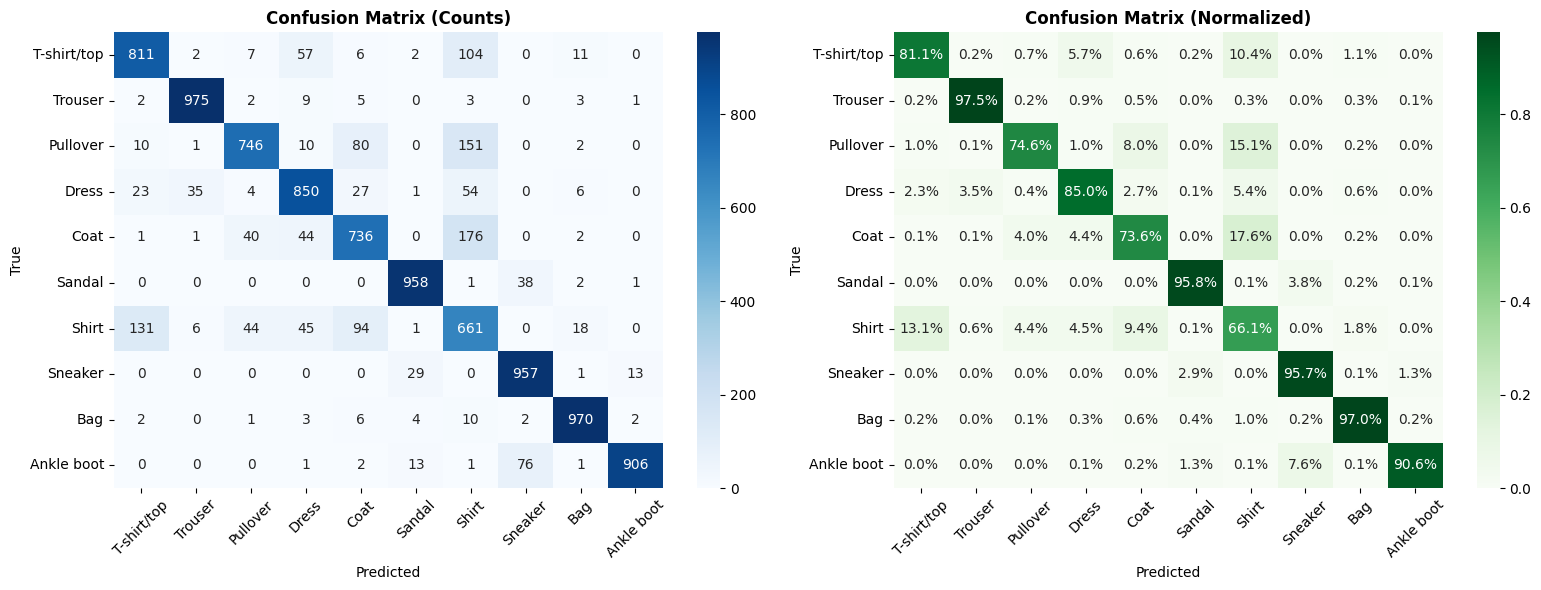

In [12]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_ylabel('True'); axes[0].set_xlabel('Predicted')
axes[0].tick_params(axis='x', rotation=45)

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Greens', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')
axes[1].set_ylabel('True'); axes[1].set_xlabel('Predicted')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

PER-CLASS ACCURACY


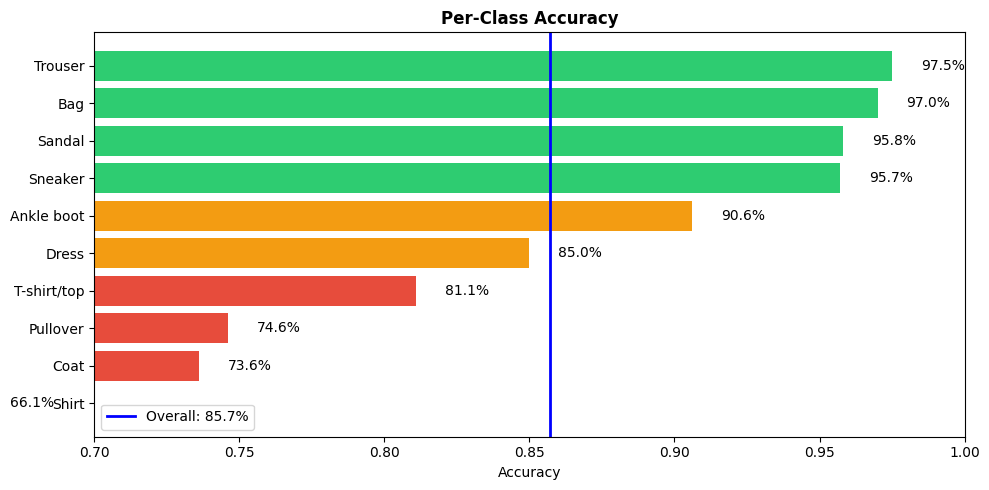

      Class  Accuracy  Correct  Total
      Shirt     0.661      661   1000
       Coat     0.736      736   1000
   Pullover     0.746      746   1000
T-shirt/top     0.811      811   1000
      Dress     0.850      850   1000
 Ankle boot     0.906      906   1000
    Sneaker     0.957      957   1000
     Sandal     0.958      958   1000
        Bag     0.970      970   1000
    Trouser     0.975      975   1000

Hardest: Shirt (66.1%)
Easiest: Trouser (97.5%)


In [13]:
# --- Per-Class Accuracy ---
print("=" * 60)
print("PER-CLASS ACCURACY")
print("=" * 60)

per_class_acc = cm.diagonal() / cm.sum(axis=1)
class_df = pd.DataFrame({'Class': class_names, 'Accuracy': per_class_acc,
                         'Correct': cm.diagonal(), 'Total': cm.sum(axis=1)}).sort_values('Accuracy')

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#e74c3c' if x < 0.85 else '#2ecc71' if x > 0.92 else '#f39c12' for x in class_df['Accuracy']]
ax.barh(class_df['Class'], class_df['Accuracy'], color=colors)
ax.axvline(x=test_accuracy, color='blue', linestyle='-', linewidth=2, label=f'Overall: {test_accuracy:.1%}')
ax.set_xlim([0.70, 1.0]); ax.set_xlabel('Accuracy')
ax.set_title('Per-Class Accuracy', fontweight='bold'); ax.legend()
for i, (acc, _) in enumerate(zip(class_df['Accuracy'], class_df['Class'])):
    ax.text(acc + 0.01, i, f'{acc:.1%}', va='center')
plt.tight_layout()
plt.show()

print(class_df.to_string(index=False))
print(f"\nHardest: {class_df.iloc[0]['Class']} ({class_df.iloc[0]['Accuracy']:.1%})")
print(f"Easiest: {class_df.iloc[-1]['Class']} ({class_df.iloc[-1]['Accuracy']:.1%})")

ERROR ANALYSIS
Misclassified: 1430 / 10000 (14.30%)


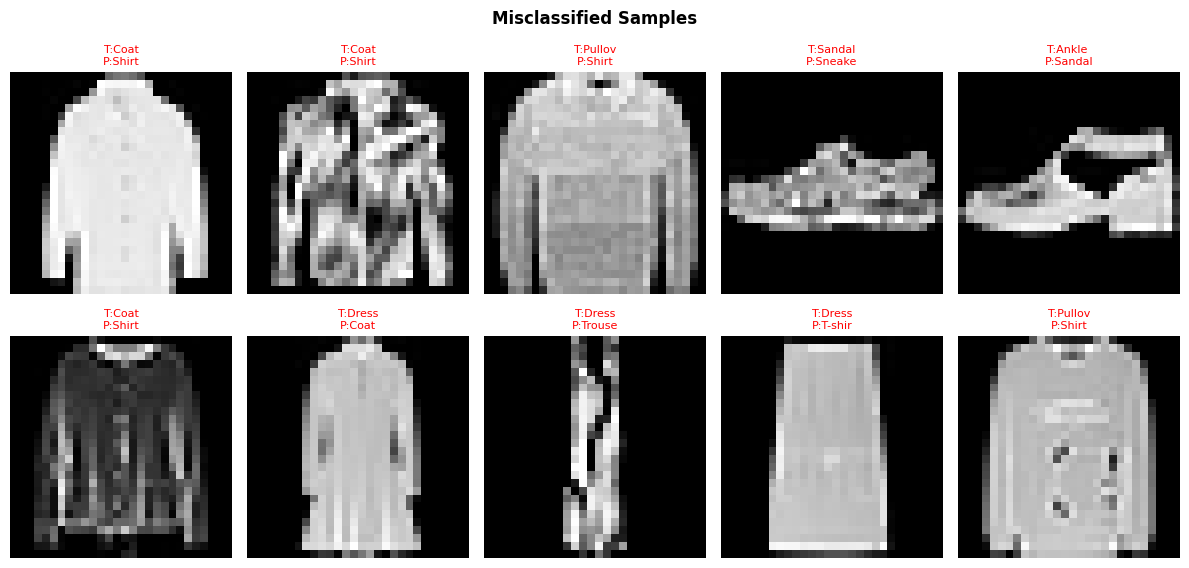


Top Misclassification Pairs:
  Coat -> Shirt: 176
  Pullover -> Shirt: 151
  Shirt -> T-shirt/top: 131
  T-shirt/top -> Shirt: 104
  Shirt -> Coat: 94


In [14]:
# --- Error Analysis ---
print("=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)

misclassified = np.where(y_pred != y_test)[0]
print(f"Misclassified: {len(misclassified)} / {len(y_test)} ({len(misclassified)/len(y_test)*100:.2f}%)")

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(misclassified):
        idx = misclassified[i]
        ax.imshow(X_test[idx].squeeze(), cmap='gray')
        ax.set_title(f'T:{class_names[y_test[idx]][:6]}\nP:{class_names[y_pred[idx]][:6]}', fontsize=8, color='red')
    ax.axis('off')
plt.suptitle('Misclassified Samples', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop Misclassification Pairs:")
pairs = Counter([(class_names[y_test[i]], class_names[y_pred[i]]) for i in misclassified]).most_common(5)
for (true, pred), count in pairs:
    print(f"  {true} -> {pred}: {count}")

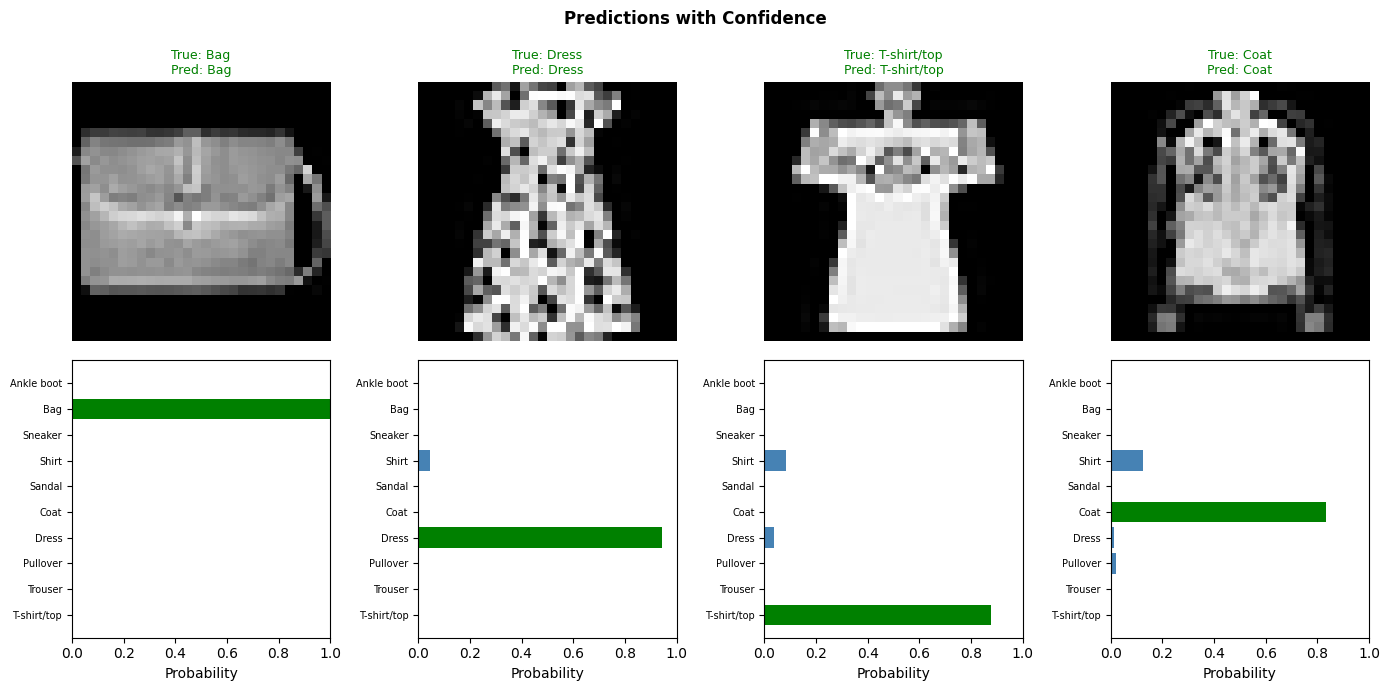

In [15]:
# --- Prediction Examples ---
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
np.random.seed(456)

for i in range(4):
    idx = np.random.randint(0, len(X_test))
    axes[0, i].imshow(X_test[idx].squeeze(), cmap='gray')
    color = 'green' if y_pred[idx] == y_test[idx] else 'red'
    axes[0, i].set_title(f'True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}', color=color, fontsize=9)
    axes[0, i].axis('off')
    
    colors_bar = ['green' if j == y_test[idx] else 'steelblue' for j in range(10)]
    axes[1, i].barh(range(10), y_pred_prob[idx], color=colors_bar)
    axes[1, i].set_yticks(range(10)); axes[1, i].set_yticklabels(class_names, fontsize=7)
    axes[1, i].set_xlim([0, 1]); axes[1, i].set_xlabel('Probability')

plt.suptitle('Predictions with Confidence', fontweight='bold')
plt.tight_layout()
plt.show()

In [16]:
# --- Final Summary ---
print("=" * 60)
print("EXPERIMENT SUMMARY")
print("=" * 60)
print(f"""
DATASET: Fashion-MNIST (10 classes, 28x28 grayscale)
  - Training: {len(X_train):,} | Validation: {len(X_val):,} | Test: {len(X_test):,}

MODEL: Custom CNN (3 conv blocks: 32->64->128 filters)
  - Parameters: {model.count_params():,}
  - Regularization: BatchNorm, Dropout (0.25-0.5)

TRAINING:
  - Optimizer: Adam | Epochs: {len(history.history['accuracy'])}
  - Data Augmentation: Rotation, Shift, Shear, Zoom, Flip
  - Callbacks: ReduceLROnPlateau, EarlyStopping

RESULTS:
  - Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)
  - Test Loss: {test_loss:.4f}
  - Misclassified: {len(misclassified)} samples ({len(misclassified)/len(y_test)*100:.2f}%)
  - Mean Confidence: {max_probs.mean():.4f}
""")

EXPERIMENT SUMMARY

DATASET: Fashion-MNIST (10 classes, 28x28 grayscale)
  - Training: 15,000 | Validation: 5,000 | Test: 10,000

MODEL: Custom CNN (3 conv blocks: 32->64->128 filters)
  - Parameters: 176,746
  - Regularization: BatchNorm, Dropout (0.25-0.5)

TRAINING:
  - Optimizer: Adam | Epochs: 8
  - Data Augmentation: Rotation, Shift, Shear, Zoom, Flip
  - Callbacks: ReduceLROnPlateau, EarlyStopping

RESULTS:
  - Test Accuracy: 0.8570 (85.70%)
  - Test Loss: 0.4060
  - Misclassified: 1430 samples (14.30%)
  - Mean Confidence: 0.8672



# **Conclusion**

This experiment demonstrates a **production-level deep learning pipeline** for image classification.

**Key Techniques:**
- **Custom CNN**: 3 convolutional blocks (32->64->128 filters) with BatchNorm and Dropout
- **Data Augmentation**: Rotation, shifts, shear, zoom, flips for better generalization
- **Adaptive Training**: ReduceLROnPlateau and EarlyStopping callbacks
- **Comprehensive Evaluation**: Confusion matrix, per-class metrics, error analysis

**Key Insights:**
- Regularization (BatchNorm + Dropout) prevents overfitting
- Data augmentation improves generalization without new data
- Some classes (Shirt vs T-shirt) are inherently harder to distinguish
- CNNs learn hierarchical features from edges to complex patterns

This pipeline demonstrates **industry best practices** for deep learning classification.